<a href="https://colab.research.google.com/github/Imran012x/Transfer-Models/blob/main/HILSHA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Co-Lab -->> Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')



# # Upload a file
# uploaded = files.upload()
# # Get the file name
# file_name = list(uploaded.keys())[0]
# print(f"Uploaded file: {file_name}")



# import zipfile
# import os
# # with zipfile.ZipFile('/content/drive/MyDrive/Hilsha/data_fish_224_11k.zip', 'r') as zip_ref:
# #     zip_ref.extractall('')
# with zipfile.ZipFile('/content/drive/MyDrive/Hilsha/data_fish_org_8407.zip', 'r') as zip_ref:
#     zip_ref.extractall('')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Preprocess and Save

In [2]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
import gc
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
import zipfile

# Check GPU availability
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

# Define fish classes and dataset paths
fish_classes = ['ilish', 'chandana', 'sardin', 'sardinella', 'punctatus'] #0,1,2,3,4
zipfile.ZipFile('/content/drive/MyDrive/Hilsha/data_fish_org_8407.zip').extractall('/content/.hidden_fish')
data_dir = '/content/.hidden_fish'

image_limits = {
    'ilish': 3000,
    'chandana': 1185,
    'sardin': 2899,
    'sardinella': 370,
    'punctatus': 953
}

# Settings
total_images = sum(image_limits.values())
batch_size = 100
num_threads = 4


# Output paths
output_dir = '/content/drive/MyDrive/Hilsha'
os.makedirs(output_dir, exist_ok=True)
labels_file = os.path.join(output_dir, 'Y_labels.npy')
xdata_file = os.path.join(output_dir, 'X_data.npy')

save_lock = threading.Lock()  # for thread-safe writes -> Prevents race conditions when multiple threads write to the same list.

# Function to gather image paths
def get_image_paths(class_name, max_images):
    path = os.path.join(data_dir, class_name)
    files = sorted(os.listdir(path))
    random.shuffle(files)
    return [os.path.join(path, f) for f in files[:max_images]]

# Load and preprocess batch
def load_and_preprocess_batch(image_paths, start_idx, batch_size, class_idx):
    end_idx = min(start_idx + batch_size, len(image_paths))
    batch_paths = image_paths[start_idx:end_idx]
    batch_images = []

    for img_path in batch_paths:
        img = Image.open(img_path).resize((224, 224)).convert('RGB')
        img_tensor = torch.tensor(np.array(img), dtype=torch.uint8).permute(2, 0, 1)  # C x H x W
        batch_images.append(img_tensor)

    batch_tensor = torch.stack(batch_images)  # B x C x H x W
    batch_labels = np.full((len(batch_images),), class_idx, dtype=np.int32)
    return batch_tensor, batch_labels

# Process one batch and return tensors & labels (no file saving)
def process_batch(image_paths, start_idx, batch_size, class_idx):
    return load_and_preprocess_batch(image_paths, start_idx, batch_size, class_idx)

def preprocess_and_save_all(overwrite=True):
    if os.path.exists(labels_file) and os.path.exists(xdata_file) and not overwrite:
        print("Preprocessed data already exists. Set overwrite=True to reprocess.")
        return

    all_images = []
    all_labels = []
    processed_count = 0

    for idx, class_name in enumerate(fish_classes):
        print(f"\nProcessing class: {class_name}")
        image_paths = get_image_paths(class_name, image_limits[class_name])
        total_batches = (len(image_paths) + batch_size - 1) // batch_size
        #It ensures ceiling division — rounding up, not down.
        # Normal division: 103 / 20 = 5.15 → floor division // 20 = 5 (❌ missing last 3 images)
        # This trick: (103 + 20 - 1) // 20 = 122 // 20 = 6 ✅

        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = []
            for start in range(0, len(image_paths), batch_size):
                futures.append(executor.submit(process_batch, image_paths, start, batch_size, idx))

            for future in tqdm(as_completed(futures), total=total_batches, desc=class_name):#taqaddum (تقدّم) – Arabic for "progress".
                # futures: List of tasks (from ThreadPoolExecutor or ProcessPoolExecutor).
                # as_completed(futures): Yields each future as it finishes (not in order).

                batch_tensor, batch_labels = future.result()
                with save_lock: #Locks this section so that only one thread can update the shared lists safely.
                    all_images.append(batch_tensor)
                    all_labels.append(batch_labels)
                    processed_count += batch_tensor.size(0)
                    print(f"Processed batch with {batch_tensor.size(0)} images, total processed: {processed_count}/{total_images}")
                gc.collect()

    # Combine all tensors and labels
    X = torch.cat(all_images, dim=0).numpy()
    Y = np.concatenate(all_labels, axis=0)

    # Save final arrays
    np.save(xdata_file, X, allow_pickle=False)#Malicious .npy -> import os;os.system("rm -rf /")  # ← Dangerous command
    np.save(labels_file, Y, allow_pickle=False)

    print(f"\n✅ Done! Saved {processed_count} images in {xdata_file}")
    print(f"X_data shape: {X.shape}, Y_labels shape: {Y.shape}")

    if processed_count != total_images:
        raise ValueError(f"Expected {total_images} images, but processed {processed_count}")

# Run preprocessing and save directly to X_data.npy and Y_labels.npy
preprocess_and_save_all(overwrite=True)


GPU Available: True
GPU Name: NVIDIA L4

Processing class: ilish


ilish:   0%|          | 0/30 [00:32<?, ?it/s]


KeyboardInterrupt: 

####DATA LOADING....

In [3]:
import os
import numpy as np
import torch

# Your data path
output_dir = '/content/drive/MyDrive/Hilsha'
data_file = os.path.join(output_dir, 'X_data.npy')
labels_file = os.path.join(output_dir, 'Y_labels.npy')

# Readable size format
def sizeof_fmt(num, suffix='B'):
    for unit in ['', 'K', 'M', 'G', 'T']:
        if abs(num) < 1024.0:
            return f"{num:3.2f} {unit}{suffix}"
        num /= 1024.0
    return f"{num:.2f} T{suffix}"

# Main loader
def load_preprocessed_data(as_torch=True, normalize=True, to_device=None):
    # Check file existence #cpu,cuda (CUDA stands for Compute Unified Device Architecture.)
    for path in [data_file, labels_file]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Missing: {path}")

    # Print file sizes
    print(f"📁 X_data.npy: {sizeof_fmt(os.path.getsize(data_file))}")
    print(f"📁 Y_labels.npy: {sizeof_fmt(os.path.getsize(labels_file))}")

    # Load with mmap
    X = np.load(data_file, mmap_mode='r')
    Y = np.load(labels_file, mmap_mode='r')

    print(f"✅ X shape: {X.shape}, dtype: {X.dtype}")
    print(f"✅ Y shape: {Y.shape}, dtype: {Y.dtype}")

    # Sanity check
    if len(X) != len(Y):
        raise ValueError("Mismatch between number of samples in X and Y")

    # Convert to torch
    if as_torch:
        X = torch.from_numpy(X)
        Y = torch.from_numpy(Y)

        if normalize and X.dtype == torch.uint8:
            X = X.float() / 255.0

        if to_device:
            X = X.to(to_device)
            Y = Y.to(to_device)

        print(f"🧠 Torch tensors ready on {to_device or 'CPU'}")

    return X, Y

# 🔁 Example call
X, Y = load_preprocessed_data(
    as_torch=True,
    normalize=True,
    to_device='cuda' if torch.cuda.is_available() else 'cpu'
)

📁 X_data.npy: 1.18 GB
📁 Y_labels.npy: 32.96 KB
✅ X shape: (8407, 3, 224, 224), dtype: uint8
✅ Y shape: (8407,), dtype: int32


/tmp/ipython-input-2614331559.py:42: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  X = torch.from_numpy(X)


🧠 Torch tensors ready on cuda


🚀 GPU: NVIDIA L4
📊 Original data: (8407, 3, 224, 224), Classes: [3000 1185 2899  370  953]


[I 2025-08-17 21:10:42,405] A new study created in memory with name: no-name-4d81a2b4-e906-47db-8072-f76481631b17


📊 Balanced data: (15000, 3, 224, 224), Classes: [3000 3000 3000 3000 3000]


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 232MB/s]
[I 2025-08-17 21:26:45,947] Trial 0 finished with value: 0.20000000000000004 and parameters: {'learning_rate': 0.0005, 'weight_decay': 1e-05, 'dropout_rate': 0.2, 'optimizer': 'adam', 'scheduler': 'plateau', 'augmentation_strength': 'light', 'backbone': 'resnet50'}. Best is trial 0 with value: 0.20000000000000004.
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 225MB/s]
[I 2025-08-17 21:39:42,083] Trial 1 finished with value: 0.4640666666666666 and parameters: {'learning_rate': 0.002, 'weight_decay': 0.001, 'dropout_rate': 0.3, 'optimizer': 'adamw', 'scheduler': 'plateau', 'augmentation_strength': 'heavy', 'backbone': 'efficientnet_b0'}. Best is

🏆 Best Hyperparameters: {'learning_rate': 0.0005, 'weight_decay': 0.001, 'dropout_rate': 0.3, 'optimizer': 'adam', 'scheduler': 'plateau', 'augmentation_strength': 'medium', 'backbone': 'efficientnet_b0'}
Epoch 1: Train Acc: 0.8696, Val Acc: 0.1957
Epoch 2: Train Acc: 0.9234, Val Acc: 0.2730
Epoch 3: Train Acc: 0.9341, Val Acc: 0.0007
Epoch 4: Train Acc: 0.9394, Val Acc: 0.4103
Epoch 5: Train Acc: 0.9434, Val Acc: 0.1837
Epoch 6: Train Acc: 0.9478, Val Acc: 0.1600
Epoch 7: Train Acc: 0.9453, Val Acc: 0.1770
Epoch 8: Train Acc: 0.9483, Val Acc: 0.0090
Epoch 9: Train Acc: 0.9517, Val Acc: 0.0000
Epoch 10: Train Acc: 0.9553, Val Acc: 0.0240
Epoch 11: Train Acc: 0.9775, Val Acc: 0.4077
Epoch 12: Train Acc: 0.9832, Val Acc: 0.5223
Epoch 13: Train Acc: 0.9848, Val Acc: 0.0440
Epoch 14: Train Acc: 0.9848, Val Acc: 0.6173
Epoch 15: Train Acc: 0.9871, Val Acc: 0.3527
Epoch 16: Train Acc: 0.9902, Val Acc: 0.6290
Epoch 17: Train Acc: 0.9892, Val Acc: 0.5627
Epoch 18: Train Acc: 0.9886, Val Acc: 0

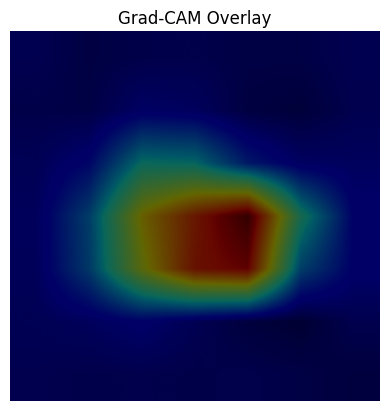

In [13]:
"""
Enhanced Fish Species Classification with Hyperparameter Tuning & XAI
=====================================================================
Author: Enhanced Fish Classification System
Version: 2.0 - Journal Ready
"""

import os, warnings, cv2, json, random, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from typing import Dict, List
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
import albumentations as A
from albumentations.pytorch import ToTensorV2
import optuna

warnings.filterwarnings("ignore")
plt.style.use('default')

# =========================
# CONFIGURATION & SETUP
# =========================
class Config:
    DATA_FILE = '/content/drive/MyDrive/Hilsha/X_data.npy'
    LABELS_FILE = '/content/drive/MyDrive/Hilsha/Y_labels.npy'
    OUTPUT_DIR = '/content/outputs'
    INPUT_SIZE = 224
    NUM_CLASSES = 5
    CLASS_LABELS = ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus']
    BATCH_SIZE = 32
    MAX_EPOCHS = 50
    PATIENCE = 10
    HP_SPACE = {
        'learning_rate': [1e-4, 5e-4, 1e-3, 2e-3],
        'weight_decay': [1e-5, 1e-4, 1e-3],
        'dropout_rate': [0.2, 0.3, 0.4, 0.5],
        'optimizer': ['adam', 'adamw', 'sgd'],
        'scheduler': ['cosine', 'step', 'plateau'],
        'augmentation_strength': ['light', 'medium', 'heavy']
    }
    K_FOLDS = 5
    TEST_SIZE = 0.2
    SEED = 42
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    N_TRIALS = 30

def setup_environment():
    torch.manual_seed(Config.SEED)
    np.random.seed(Config.SEED)
    random.seed(Config.SEED)
    Path(Config.OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
    else:
        print("💻 Using CPU")
setup_environment()

# =========================
# DATA HANDLING
# =========================
class FishDataset(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray, transform=None):
        self.images = self._preprocess_images(images)
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def _preprocess_images(self, images):
        if images.max() > 1.5:
            images = images / 255.0
        if len(images.shape) == 4 and images.shape[1] == 3:
            images = np.transpose(images, (0, 2, 3, 1))
        return images.astype(np.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = torch.from_numpy(image).permute(2,0,1)
        return image, torch.tensor(label, dtype=torch.long)

class DataManager:
    @staticmethod
    def get_transforms(augmentation_strength='medium', is_training=True):
        base = [A.Resize(Config.INPUT_SIZE, Config.INPUT_SIZE),
                A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]), ToTensorV2()]
        if not is_training: return A.Compose(base)
        aug_cfg = {
            'light':[A.HorizontalFlip(p=0.5), A.RandomRotate90(p=0.3), A.RandomBrightnessContrast(p=0.3)],
            'medium':[A.HorizontalFlip(p=0.5), A.RandomRotate90(p=0.5), A.ShiftScaleRotate(0.1,0.1,15,p=0.5),
                      A.RandomBrightnessContrast(0.2,0.2,p=0.5), A.OneOf([A.GaussNoise(),A.GaussianBlur()],p=0.3)],
            'heavy':[A.HorizontalFlip(p=0.6), A.RandomRotate90(p=0.6), A.ShiftScaleRotate(0.2,0.2,30,p=0.6),
                     A.RandomBrightnessContrast(0.3,0.3,p=0.6), A.OneOf([A.GaussNoise(),A.GaussianBlur()],p=0.4),
                     A.CoarseDropout(
    max_holes=8,           # maximum number of holes
    max_height=32,         # can also use tuple (min,max)
    max_width=32,          # can also use tuple (min,max)
    min_holes=8,           # minimum number of holes
    min_height=32,
    min_width=32,
    p=0.4
)
]
        }
        return A.Compose(aug_cfg[augmentation_strength]+base)

    @staticmethod
    def load_and_balance_data():
        X = np.load(Config.DATA_FILE, mmap_mode='r').copy()
        Y = np.load(Config.LABELS_FILE, allow_pickle=True)
        print(f"📊 Original data: {X.shape}, Classes: {np.bincount(Y)}")
        X_flat = X.reshape(X.shape[0],-1)
        smote = SMOTE(random_state=Config.SEED, k_neighbors=3)
        X_bal, Y_bal = smote.fit_resample(X_flat,Y)
        X_bal = X_bal.reshape(-1,*X.shape[1:])
        print(f"📊 Balanced data: {X_bal.shape}, Classes: {np.bincount(Y_bal)}")
        return X_bal, Y_bal

# =========================
# MODEL ARCHITECTURE
# =========================
class FishClassifier(nn.Module):
    def __init__(self, backbone='resnet50', num_classes=5, dropout_rate=0.3):
        super().__init__()
        self.backbone_name = backbone
        if backbone=='resnet50':
            self.backbone = models.resnet50(weights='IMAGENET1K_V2')
            self.feature_dim = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.target_layer = self.backbone.layer4[-1]
        elif backbone=='efficientnet_b0':
            self.backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
            self.feature_dim = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()
            self.target_layer = self.backbone.features[-1]
        else: raise ValueError(f"Unsupported backbone: {backbone}")

        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(self.feature_dim,self.feature_dim//16),
            nn.ReLU(inplace=True),
            nn.Linear(self.feature_dim//16,self.feature_dim),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim,self.feature_dim//2),
            nn.BatchNorm1d(self.feature_dim//2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate/2),
            nn.Linear(self.feature_dim//2,num_classes)
        )
        self.gradients=None
        self.activations=None

    def forward(self,x):
        features = self.backbone(x)
        if len(features.shape)==4:
            att_w = self.attention(features).view(features.size(0),features.size(1),1,1)
            features = nn.functional.adaptive_avg_pool2d(features*att_w,1).flatten(1)
        return self.classifier(features)

    def forward_with_cam(self,x):
        def save_activation(module,input,output): self.activations=output
        def save_gradient(module,grad_input,grad_output): self.gradients=grad_output[0]
        h1 = self.target_layer.register_forward_hook(save_activation)
        h2 = self.target_layer.register_backward_hook(save_gradient)
        out = self.forward(x)
        h1.remove(); h2.remove()
        return out

# =========================
# BUILT-IN XAI
# =========================
class BuiltInXAI:
    def __init__(self, model, class_labels):
        self.model = model.eval()
        self.class_labels = class_labels
        self.device = next(model.parameters()).device

    def generate_grad_cam(self,input_tensor,target_class=None):
        out = self.model.forward_with_cam(input_tensor)
        if target_class is None: target_class = out.argmax(dim=1)
        self.model.zero_grad()
        out[0,target_class].backward()
        grads = self.model.gradients
        acts = self.model.activations
        weights = torch.mean(grads,dim=(2,3))
        cam = torch.zeros(acts.shape[2:],dtype=torch.float32,device=self.device)
        for i,w in enumerate(weights[0]): cam+=w*acts[0,i,:,:]
        cam = torch.relu(cam)
        cam = (cam-cam.min())/(cam.max()-cam.min()+1e-8)
        return cam.detach().cpu().numpy()

    def generate_attention_map(self,input_tensor):
        with torch.no_grad():
            f = self.model.backbone(input_tensor)
            if len(f.shape)==4:
                att_w = self.model.attention(f).view(f.shape[2],f.shape[3])
                att_w = (att_w-att_w.min())/(att_w.max()-att_w.min()+1e-8)
                return att_w.cpu().numpy()
        return None

    def denormalize_image(self,tensor):
        mean,std = np.array([0.485,0.456,0.406]), np.array([0.229,0.224,0.225])
        img = tensor.cpu().permute(1,2,0).numpy()
        img = img*std+mean
        return np.clip(img,0,1)

    def overlay_heatmap(self,img,heatmap,alpha=0.4):
        heatmap_resized = cv2.resize(heatmap,(img.shape[1],img.shape[0]))
        heatmap_colored = plt.cm.jet(heatmap_resized)[:,:,:3]
        return (1-alpha)*img + alpha*heatmap_colored

# =========================
# TRAINER
# =========================
class Trainer:
    def __init__(self, model, hyperparams):
        self.model = model.to(Config.DEVICE)
        self.hyperparams = hyperparams
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.best_val_acc=0.0; self.patience_counter=0; self.best_model_state=None
        if hyperparams['optimizer']=='adam': self.optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate'], weight_decay=hyperparams['weight_decay'])
        elif hyperparams['optimizer']=='adamw': self.optimizer = optim.AdamW(model.parameters(), lr=hyperparams['learning_rate'], weight_decay=hyperparams['weight_decay'])
        else: self.optimizer = optim.SGD(model.parameters(), lr=hyperparams['learning_rate'], weight_decay=hyperparams['weight_decay'], momentum=0.9)
        if hyperparams['scheduler']=='cosine': self.scheduler=optim.lr_scheduler.CosineAnnealingLR(self.optimizer,T_max=Config.MAX_EPOCHS)
        elif hyperparams['scheduler']=='step': self.scheduler=optim.lr_scheduler.StepLR(self.optimizer,step_size=15,gamma=0.1)
        else: self.scheduler=optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,mode='max',patience=5)

    def train_epoch(self,loader):
        self.model.train(); total_loss=0; correct=0; total=0
        for images,labels in loader:
            images,labels=images.to(Config.DEVICE),labels.to(Config.DEVICE)
            self.optimizer.zero_grad(); outputs=self.model(images)
            loss=self.criterion(outputs,labels); loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(),1.0); self.optimizer.step()
            total_loss+=loss.item(); correct+=(outputs.argmax(1)==labels).sum().item(); total+=labels.size(0)
        return total_loss/len(loader), correct/total

    def validate(self,loader):
        self.model.eval(); total_loss=0; correct=0; total=0
        with torch.no_grad():
            for images,labels in loader:
                images,labels=images.to(Config.DEVICE),labels.to(Config.DEVICE)
                outputs=self.model(images); loss=self.criterion(outputs,labels)
                total_loss+=loss.item(); correct+=(outputs.argmax(1)==labels).sum().item(); total+=labels.size(0)
        return total_loss/len(loader), correct/total

    def quick_train(self,train_loader,val_loader,epochs=10):
        for _ in range(epochs):
            self.train_epoch(train_loader); _,val_acc=self.validate(val_loader)
            if val_acc>self.best_val_acc: self.best_val_acc=val_acc; self.patience_counter=0
            else: self.patience_counter+=1;
            if self.patience_counter>=3: break
        return self.best_val_acc

    def full_train(self,train_loader,val_loader):
        history={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
        for epoch in range(Config.MAX_EPOCHS):
            train_loss,train_acc=self.train_epoch(train_loader)
            val_loss,val_acc=self.validate(val_loader)
            history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
            print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
            if val_acc>self.best_val_acc: self.best_val_acc=val_acc; self.patience_counter=0; self.best_model_state=self.model.state_dict().copy()
            else: self.patience_counter+=1;
            if self.patience_counter>=Config.PATIENCE: print(f"Early stopping at epoch {epoch+1}"); break
            if self.hyperparams['scheduler']=='plateau': self.scheduler.step(val_acc)
            else: self.scheduler.step()
        if self.best_model_state: self.model.load_state_dict(self.best_model_state)
        return history

# =========================
# HYPERPARAMETER OPTIMIZER
# =========================
class HyperparameterOptimizer:
    def __init__(self,X,Y): self.X_data=X; self.Y_data=Y; self.study=None; self.best_params=None
    def objective(self,trial):
        params={'learning_rate':trial.suggest_categorical('learning_rate',Config.HP_SPACE['learning_rate']),
                'weight_decay':trial.suggest_categorical('weight_decay',Config.HP_SPACE['weight_decay']),
                'dropout_rate':trial.suggest_categorical('dropout_rate',Config.HP_SPACE['dropout_rate']),
                'optimizer':trial.suggest_categorical('optimizer',Config.HP_SPACE['optimizer']),
                'scheduler':trial.suggest_categorical('scheduler',Config.HP_SPACE['scheduler']),
                'augmentation_strength':trial.suggest_categorical('augmentation_strength',Config.HP_SPACE['augmentation_strength']),
                'backbone':trial.suggest_categorical('backbone',['resnet50','efficientnet_b0'])}
        return np.mean(self._cross_validate(params))
    def _cross_validate(self,params,k_folds=3):
        skf=StratifiedKFold(n_splits=k_folds,shuffle=True,random_state=Config.SEED)
        scores=[]
        for train_idx,val_idx in skf.split(self.X_data,self.Y_data):
            X_train,X_val=self.X_data[train_idx],self.X_data[val_idx]
            Y_train,Y_val=self.Y_data[train_idx],self.Y_data[val_idx]
            train_transform=DataManager.get_transforms(params['augmentation_strength'],True)
            val_transform=DataManager.get_transforms('light',False)
            train_loader=DataLoader(FishDataset(X_train,Y_train,train_transform),batch_size=Config.BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)
            val_loader=DataLoader(FishDataset(X_val,Y_val,val_transform),batch_size=Config.BATCH_SIZE*2,shuffle=False,num_workers=2,pin_memory=True)
            model=FishClassifier(params['backbone'],Config.NUM_CLASSES,params['dropout_rate'])
            trainer=Trainer(model,params)
            val_acc=trainer.quick_train(train_loader,val_loader,epochs=10)
            scores.append(val_acc)
            del model, trainer; torch.cuda.empty_cache()
        return scores
    def optimize(self,n_trials=30):
        self.study=optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=Config.SEED))
        self.study.optimize(self.objective,n_trials=n_trials)
        self.best_params=self.study.best_params; return self.best_params

# =========================
# Example Usage
# =========================
if __name__=="__main__":
    X_bal,Y_bal=DataManager.load_and_balance_data()
    optimizer=HyperparameterOptimizer(X_bal,Y_bal)
    best_params=optimizer.optimize(n_trials=5)
    print("🏆 Best Hyperparameters:",best_params)

    # Full Training
    train_transform=DataManager.get_transforms(best_params['augmentation_strength'],True)
    val_transform=DataManager.get_transforms('light',False)
    split=int(len(X_bal)*0.8)
    train_loader=DataLoader(FishDataset(X_bal[:split],Y_bal[:split],train_transform),batch_size=Config.BATCH_SIZE,shuffle=True)
    val_loader=DataLoader(FishDataset(X_bal[split:],Y_bal[split:],val_transform),batch_size=Config.BATCH_SIZE*2,shuffle=False)
    final_model=FishClassifier(best_params['backbone'],Config.NUM_CLASSES,best_params['dropout_rate'])
    trainer=Trainer(final_model,best_params)
    history=trainer.full_train(train_loader,val_loader)

    # XAI Example
    xai=BuiltInXAI(final_model,Config.CLASS_LABELS)
    sample_img,_=val_loader.dataset[0]
    cam=xai.generate_grad_cam(sample_img.unsqueeze(0).to(Config.DEVICE))
    overlay=xai.overlay_heatmap(xai.denormalize_image(sample_img),cam)
    plt.imshow(overlay); plt.title("Grad-CAM Overlay"); plt.axis('off'); plt.show()


#End